In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

from NeuralNet import NeuralNet

Part 1: Dataset selection
Source Webpage: [Kaggle House Prices Competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

In [3]:
# Load the dataset
df = pd.read_csv('data/train.csv')

# Display basic information
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Part 2: Data processing

In [4]:
df['SalePrice'] = np.log1p(df['SalePrice'])
df = df.drop(df[(df['GrLivArea']>4000) & (df['SalePrice']<12.5)].index)

X = df.drop(['Id', 'SalePrice'], axis=1)
y = df['SalePrice'].to_numpy()

numerical_cols = X.select_dtypes(include=np.number).columns
categorical_cols = X.select_dtypes(include='object').columns

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='None')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

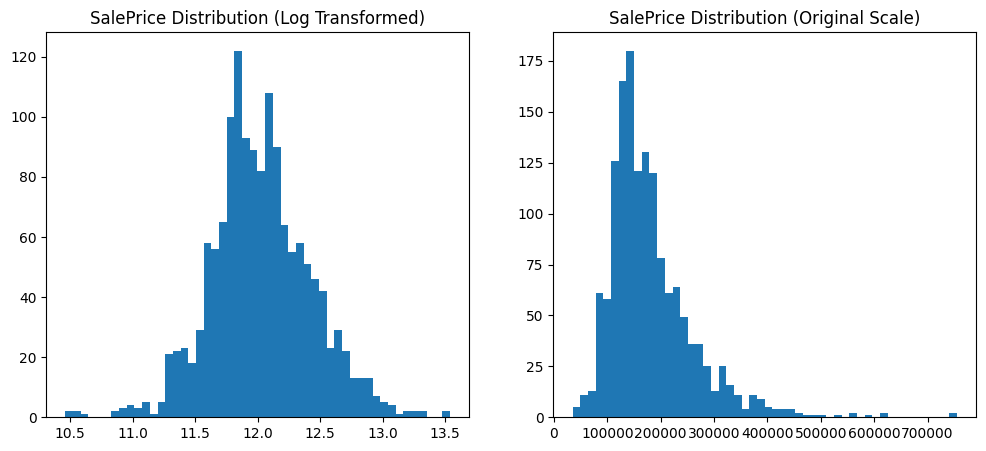

In [5]:
# Price of houses before and after log transformation
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(df['SalePrice'], bins=50)
plt.title('SalePrice Distribution (Log Transformed)')
plt.subplot(1, 2, 2)
plt.hist(np.expm1(df['SalePrice']), bins=50)
plt.title('SalePrice Distribution (Original Scale)')
plt.show()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_scaled = preprocessor.fit_transform(X_train).toarray()
X_test_scaled = preprocessor.transform(X_test).toarray()

print("Training data shape:", X_train_scaled.shape)
print("Testing data shape:", X_test_scaled.shape)

Training data shape: (1166, 299)
Testing data shape: (292, 299)


In [7]:
np.savez('data.npz', X_train=X_train_scaled, y_train=y_train, X_test=X_test_scaled, y_test=y_test)

Part 3: Obtaining and comparing predictions

In [8]:
def evaluate_model(y_true, y_pred, model_name):
    y_true_exp = np.expm1(y_true)
    y_pred_exp = np.expm1(y_pred)

    mse = mean_squared_error(y_true_exp, y_pred_exp)
    mae = mean_absolute_error(y_true_exp, y_pred_exp)
    mape = mean_absolute_percentage_error(y_true_exp, y_pred_exp)

    print(f"--- {model_name} Evaluation ---")
    print(f"MSE:  ${mse:,.2f}")
    print(f"MAE:  ${mae:,.2f}")
    print(f"MAPE: {mape:.2%}")

    return {'Model': model_name, 'MSE': mse, 'MAE': mae, 'MAPE': mape}

def plot_predictions(y_true, y_pred, model_name):
    plt.figure()
    plt.scatter(y_true, y_pred, label='Predictions')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], label='Ideal Fit')
    plt.xlabel("Actual Sale Price (Log)")
    plt.ylabel("Predicted Sale Price (Log)")
    plt.show()

def plot_loss(train_loss, val_loss, model_name):
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Mean Squared Error")
    plt.show()

Part 3.1: BP

In [9]:
n_features = X_train_scaled.shape[1]
hyperparameters = [
    {'layers': [n_features, 64, 1], 'lr': 0.01, 'mom': 0.5, 'act': 'sigmoid', 'epochs': 100},
    {'layers': [n_features, 64, 1], 'lr': 0.01, 'mom': 0.5, 'act': 'tanh', 'epochs': 100},
    {'layers': [n_features, 64, 1], 'lr': 0.005, 'mom': 0.7, 'act': 'relu', 'epochs': 100},
    {'layers': [n_features, 128, 1], 'lr': 0.001, 'mom': 0.9, 'act': 'relu', 'epochs': 150},
    {'layers': [n_features, 64, 32, 1], 'lr': 0.01, 'mom': 0.5, 'act': 'relu', 'epochs': 150}
]

results_list = []
best_model_info = {'mae': float('inf'), 'model': None, 'params': None, 'history': None}

for i, params in enumerate(hyperparameters):
    print(f"\n--- Training Combination {i+1}/{len(hyperparameters)} ---")
    print(f"Params: {params}")

    nn = NeuralNet(
        layers=params['layers'],
        learning_rate=params['lr'],
        momentum=params['mom'],
        activation=params['act'],
        epochs=params['epochs']
    )

    nn.fit(X_train_scaled, y_train)
    y_pred = nn.predict(X_test_scaled)

    eval_metrics = evaluate_model(y_test, y_pred, f"Custom BP Combo {i+1}")

    results_list.append({
        'Combination': i+1,
        'Layer Structure': str(params['layers']),
        'Num epochs': params['epochs'],
        'Learning Rate': params['lr'],
        'Momentum': params['mom'],
        'Activation': params['act'],
        'MSE': eval_metrics['MSE'],
        'MAE': eval_metrics['MAE'],
        'MAPE': eval_metrics['MAPE']
    })
    if eval_metrics['MAE'] < best_model_info['mae']:
        best_model_info['mae'] = eval_metrics['MAE']
        best_model_info['model'] = nn
        best_model_info['params'] = params
        best_model_info['history'] = nn.loss_epochs()
        best_model_info['name'] = f"Custom BP Combo {i+1} (Best)"

results_df = pd.DataFrame(results_list)
results_df.sort_values(by='MAE')
results_df


--- Training Combination 1/5 ---
Params: {'layers': [299, 64, 1], 'lr': 0.01, 'mom': 0.5, 'act': 'sigmoid', 'epochs': 100}
--- Custom BP Combo 1 Evaluation ---
MSE:  $38,417,982,214.33
MAE:  $181,367.73
MAPE: 100.00%

--- Training Combination 2/5 ---
Params: {'layers': [299, 64, 1], 'lr': 0.01, 'mom': 0.5, 'act': 'tanh', 'epochs': 100}
--- Custom BP Combo 2 Evaluation ---
MSE:  $38,417,982,213.23
MAE:  $181,367.73
MAPE: 100.00%

--- Training Combination 3/5 ---
Params: {'layers': [299, 64, 1], 'lr': 0.005, 'mom': 0.7, 'act': 'relu', 'epochs': 100}
--- Custom BP Combo 3 Evaluation ---
MSE:  $723,065,209.61
MAE:  $19,241.54
MAPE: 11.98%

--- Training Combination 4/5 ---
Params: {'layers': [299, 128, 1], 'lr': 0.001, 'mom': 0.9, 'act': 'relu', 'epochs': 150}
--- Custom BP Combo 4 Evaluation ---
MSE:  $1,262,995,270.08
MAE:  $24,267.81
MAPE: 14.84%

--- Training Combination 5/5 ---
Params: {'layers': [299, 64, 32, 1], 'lr': 0.01, 'mom': 0.5, 'act': 'relu', 'epochs': 150}
--- Custom BP Com

,Combination,Layer Structure,Num epochs,Learning Rate,Momentum,Activation,MSE,MAE,MAPE
0,1,"[299, 64, 1]",100,0.010,0.5,sigmoid,3.841798e+10,181367.733779,0.999989
1,2,"[299, 64, 1]",100,0.010,0.5,tanh,3.841798e+10,181367.733776,0.999989
2,3,"[299, 64, 1]",100,0.005,0.7,relu,7.230652e+08,19241.540029,0.119824
3,4,"[299, 128, 1]",150,0.001,0.9,relu,1.262995e+09,24267.812135,0.148404
4,5,"[299, 64, 32, 1]",150,0.010,0.5,relu,7.384018e+08,18790.894082,0.110559


Displaying plots for the best model: Custom BP Combo 5 (Best)
Best parameters found: {'layers': [299, 64, 32, 1], 'lr': 0.01, 'mom': 0.5, 'act': 'relu', 'epochs': 150}


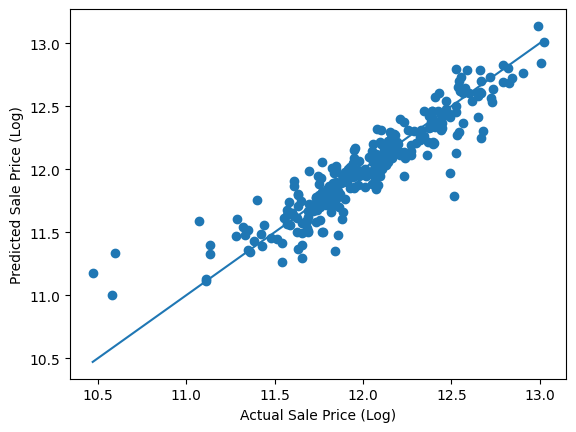

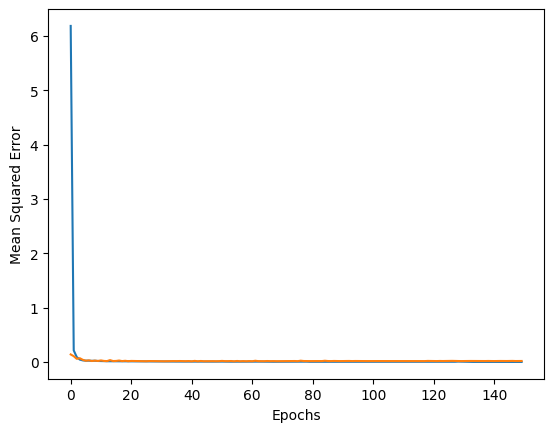

In [10]:
best_nn = best_model_info['model']
best_name = best_model_info['name']
y_pred_best_nn = best_nn.predict(X_test_scaled)

print(f"Displaying plots for the best model: {best_name}")
print(f"Best parameters found: {best_model_info['params']}")

plot_predictions(y_test, y_pred_best_nn, best_name)
train_loss, val_loss = best_model_info['history']
plot_loss(train_loss, val_loss, best_name)

Part 3.2: BP, BP-F, MLR-F

--- BP Evaluation ---
MSE:  $738,401,757.67
MAE:  $18,790.89
MAPE: 11.06%


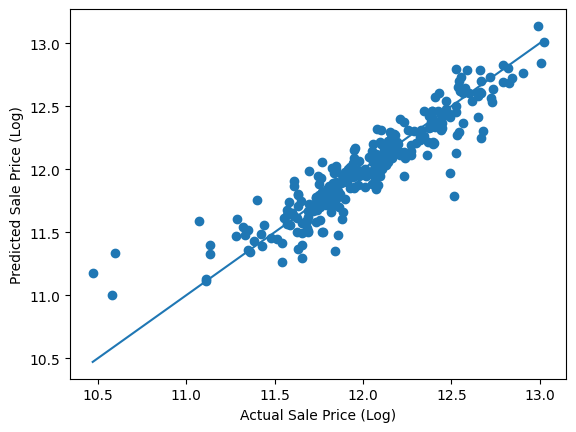

--- MLR-F Evaluation ---
MSE:  $474,643,367.87
MAE:  $15,454.62
MAPE: 9.57%


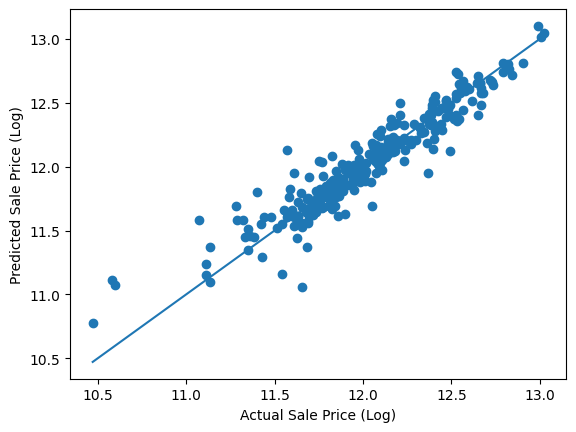

--- BP-F Evaluation ---
MSE:  $1,627,736,450.97
MAE:  $27,940.37
MAPE: 16.55%


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


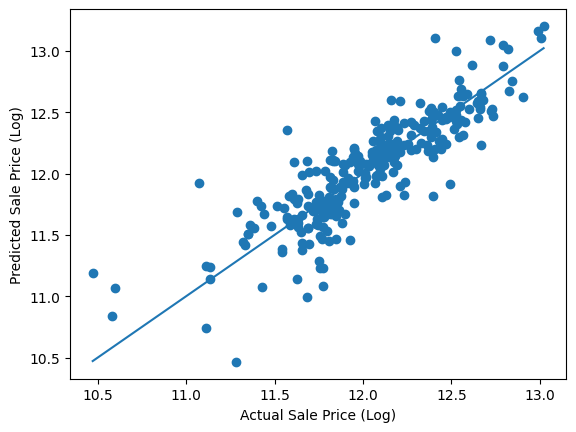

In [11]:
eval_bp = evaluate_model(y_test, y_pred_best_nn, "BP")
plot_predictions(y_test, y_pred_best_nn, "BP")

# MLR-F
mlr = LinearRegression()
mlr.fit(X_train_scaled, y_train)
y_pred_mlr = mlr.predict(X_test_scaled)
eval_mlr = evaluate_model(y_test, y_pred_mlr, "MLR-F")
plot_predictions(y_test, y_pred_mlr, "MLR-F")

# BP-F
bp_f = MLPRegressor(hidden_layer_sizes=(64, ), activation='relu', solver='sgd',
                     learning_rate_init=0.01, momentum=0.5, max_iter=150, random_state=42)
bp_f.fit(X_train_scaled, y_train)
y_pred_bp_f = bp_f.predict(X_test_scaled)
eval_bp_f = evaluate_model(y_test, y_pred_bp_f, "BP-F")
plot_predictions(y_test, y_pred_bp_f, "BP-F")

Comparision

In [12]:
final_comparison_df = pd.DataFrame([eval_bp, eval_mlr, eval_bp_f])
final_comparison_df.sort_values(by='MAE').reset_index(drop=True)

,Model,MSE,MAE,MAPE
0,MLR-F,4.746434e+08,15454.619424,0.095740
1,BP,7.384018e+08,18790.894082,0.110559
2,BP-F,1.627736e+09,27940.373468,0.165530


Optional 1

In [15]:
def build_regularized_model(l2_reg=0.0, dropout_rate=0.0):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(n_features,), kernel_regularizer=l2(l2_reg)),
        Dropout(dropout_rate),
        Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)),
        Dropout(dropout_rate),
        Dense(1) # Linear output layer for regression
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Model with L2 Regularization
model_l2 = build_regularized_model(l2_reg=0.01, dropout_rate=0.0)
model_l2.fit(X_train_scaled, y_train, epochs=150, validation_split=0.2, verbose=0, batch_size=32)
y_pred_l2 = model_l2.predict(X_test_scaled).flatten()
eval_l2 = evaluate_model(y_test, y_pred_l2, "BP-F (Keras) with L2")

# Model with Dropout
model_dropout = build_regularized_model(l2_reg=0.0, dropout_rate=0.4)
model_dropout.fit(X_train_scaled, y_train, epochs=150, validation_split=0.2, verbose=0, batch_size=32)
y_pred_dropout = model_dropout.predict(X_test_scaled).flatten()
eval_dropout = evaluate_model(y_test, y_pred_dropout, "BP-F (Keras) with Dropout")

pd.DataFrame([eval_bp_f, eval_l2, eval_dropout])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
--- BP-F (Keras) with L2 Evaluation ---
MSE:  $1,079,778,705.87
MAE:  $24,188.75
MAPE: 15.65%


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
--- BP-F (Keras) with Dropout Evaluation ---
MSE:  $3,784,157,233.51
MAE:  $46,700.28
MAPE: 23.91%


,Model,MSE,MAE,MAPE
0,BP-F,1.627736e+09,27940.373468,0.165530
1,BP-F (Keras) with L2,1.079779e+09,24188.751686,0.156524
2,BP-F (Keras) with Dropout,3.784157e+09,46700.282441,0.239140


Optional 2

Optional 3